# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Machine-learning-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import random
import glob
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import GEORGE_Library as GEORGE
import sys
sys.path.append("BestBGRemove")
from BestBGRemove import do_image
sys.path.append("Detection_to_XML")
from Detection_to_XML import CreateXMLfile
sys.path.append("xml_to_csv")
from xml_to_csv import xml_to_csv
%matplotlib inline

print("Done")

Done


## Define global variables

In [7]:
category_index = {1: {'id': 1, 'name': 'none'}, 2: {'id': 2, 'name': 'pollen'}, 3: {'id': 3, 'name': 'varroa'}, 4: {'id': 4, 'name': 'wasps'}}
train_augmented_fp = "Dataset/TrainAugmented"
val_augmented_fp = "Dataset/ValAugmented"
IMAGE_WIDTH = 75
IMAGE_HEIGHT = 150
EX_SUB = 1
VAL_SIZE = 0.1
FILL_IMG = 0 # need to change; inpaint only works with 3-channel images
num_sets = 1

print("Done")

Done


## Load Datasets and Augment

Image format is a uint8 numpy array with shape (img_height, img_width, 3)
label format is an array of four values, either 0 or 1 (e.g [0, 1, 0, 0] for pollen), where the first value corresponding to "none" is omitted.

In [6]:
try:
    files = os.listdir(train_augmented_fp)
    for file in files:
        file_path = os.path.join(train_augmented_fp, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
    files = os.listdir(val_augmented_fp)
    for file in files:
        file_path = os.path.join(val_augmented_fp, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
except OSError:
    print("Error")

dataset_paths = {
                 'PD': {'none': {'path': 'Dataset/PollenDataset/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/PollenDataset/Pollen', 'label': [1, 0, 0]}},
                 'BA': {'none': {'path': 'Dataset/BeeAlarmed/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/BeeAlarmed/Pollen', 'label': [1, 0, 0]},
                        'varroa': {'path': 'Dataset/BeeAlarmed/Varroa', 'label': [0, 1, 0]},
                        'wasps': {'path': 'Dataset/BeeAlarmed/Wasps', 'label': [0, 0, 1]}},
                 'YM': {'none': {'path': 'Dataset/YangModel/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/YangModel/Pollen', 'label': [1, 0, 0]},
                        'varroa': {'path': 'Dataset/YangModel/Varroa', 'label': [0, 1, 0]}},
                }
                 # 'USU': {'none': {'path': 'Dataset/USU/None', 'label': [0, 0, 0]},
                 #         'pollen': {'path': 'Dataset/USU/Pollen', 'label': [1, 0, 0]},
                 #         'varroa': {'path': 'Dataset/USU/Varroa', 'label': [0, 1, 0]}}}

train_random_file_list = []
val_random_file_list = []
for i in range(num_sets):
    file_list = []
    for dataset_path in dataset_paths:
        for dataset in dataset_paths[dataset_path]:
            [file_list.append(i) for i in glob.glob(dataset_paths[dataset_path][dataset]['path'] + '/*')]
    p = np.random.permutation(len(file_list))
    train_random_file_list = [file_list[i] for i in p[0:(round(len(file_list) * (1 - VAL_SIZE)))]]
    val_random_file_list = [file_list[i] for i in p[(round(len(file_list) * (1 - VAL_SIZE))):len(file_list)]]

    with tqdm(total=len(file_list), unit="images", desc=str("Augment and save dataset images")) as pbar:
        for dataset_path in dataset_paths:
            for dataset in dataset_paths[dataset_path]:
                for filename in glob.glob(dataset_paths[dataset_path][dataset]['path'] + '/*'):
                    image = Image.open(filename).convert('RGB')
                    new_image = image
                    if max(image.size) < min(IMAGE_WIDTH, IMAGE_HEIGHT):
                        ind = (image.size).index(max(image.size))
                        size = np.zeros(2)
                        size[ind] = min(IMAGE_WIDTH, IMAGE_HEIGHT)
                        size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
                        new_image = image.resize((round(size[0]), round(size[1])))
                    elif min(image.size) > max(IMAGE_WIDTH, IMAGE_HEIGHT):
                        ind = (image.size).index(min(image.size))
                        size = np.zeros(2)
                        size[ind] = max(IMAGE_WIDTH, IMAGE_HEIGHT)
                        size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
                        new_image = image.resize((round(size[0]), round(size[1])))
                    if np.array(new_image).max() <= 1:
                        new_image = np.array(new_image) * 255
                    new_image = GEORGE.automatic_brightness_and_contrast(np.array(new_image).astype('uint8'))
                    new_image = GEORGE.zoom_image(new_image)
                    if EX_SUB:
                        if filename.split("/")[1] == "PollenDataset":
                            starting_params = [159, 217, 81, [], 84, 191, 1, 9, 5.706, 3]
                            new_image, _ = do_image(np.array(new_image), *starting_params)
                            #Image.fromarray(img1).save(tmp_fp + filename.split("\\")[0] + "\\" + filename.split("\\")[-1].split(".")[0] + ".png")
                        elif filename.split("/")[1] == "BeeAlarmed":
                            starting_params = [71, 203, 177, [], 134, 209, 1, 9, 3.204, 9]
                            new_image, _ = do_image(np.array(new_image), *starting_params)
                            #Image.fromarray(img1).save(tmp_fp + filename.split("\\")[0] + "\\" + filename.split("\\")[-1].split(".")[0] + ".png")
                        elif filename.split("/")[1] == "YangModel":
                            pass
                    new_image, new_coords = GEORGE.process_image(np.array(new_image).astype('uint8'))
                    cat = str(GEORGE.get_label(dataset_paths[dataset_path][dataset]['label'])[2][0])
                    str_name = []
                    for coord in new_coords:
                        str_name.append(str(coord).split('.')[1])
                    new_filename = "%s%s_%s_%s_%s_%s.png" % (cat, str_name[0], str_name[1], str_name[2], str_name[3], str(i + 1))
                    if FILL_IMG:
                        h, w, _ = np.shape(new_image)
                        mask = np.array(new_image).astype('uint8')
                        for x in range(w):
                            for y in range(h):
                                if np.shape(mask)[2] == 3:
                                    if sum(mask[x][y]) == 0:
                                        mask[x][y] = [255, 255, 255]
                                    else:
                                        mask[x][y] = [0, 0, 0]
                                elif np.shape(mask)[2] == 4:
                                    if sum(mask[x][y]) == 0:
                                        mask[x][y] = [255, 255, 255, 255]
                                    else:
                                        mask[x][y] = [0, 0, 0, 0]
                        if np.shape(mask)[2] == 3:
                            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                        elif np.shape(mask)[2] == 4:
                            mask = cv2.cvtColor(mask, cv2.COLOR_BGRA2GRAY)
                        new_image = cv2.inpaint(np.array(new_image).astype('uint8'), mask, 5, cv2.INPAINT_NS)
                    if filename in val_random_file_list:
                        Image.fromarray(np.array(new_image).astype('uint8')).save(val_augmented_fp + "/" + new_filename,"PNG")
                    else:
                        Image.fromarray(np.array(new_image).astype('uint8')).save(train_augmented_fp + "/" + new_filename,"PNG")
                    pbar.update(1)

print("Training set: {}, Validation set: {}".format(len(train_random_file_list), len(val_random_file_list)))

Augment and save dataset images:  72%|████████████████████████████▋           | 7187/10015 [08:33<03:22, 13.99images/s]

Training set: 9014, Validation set: 1001


## Fleshing out xml and csv file generation

## XML generation

In [ ]:
offset = 30
sct = mss.mss()
yolo = Load_Yolo_model()
while True:
    img = np.array(sct.grab({"top": 87-offset, "left": 1920, "width": 1280, "height": 720, "mon": -1}))
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    image, bboxes = detect_enemy(yolo, np.copy(img), input_size=YOLO_INPUT_SIZE, CLASSES=TRAIN_CLASSES, rectangle_colors=(255,0,0))
    if len(bboxes) > 0:
        CreateXMLfile("XML_Detections", str(int(time.time())), img, bboxes, read_class_names(TRAIN_CLASSES))
        print("got it")
        time.sleep(2)

## CSV generation from xml

In [ ]:
#Original code
image_path = os.path.join(os.getcwd(), 'annotations')
xml_df = xml_to_csv(image_path)
xml_df.to_csv('raccoon_labels.csv', index=None)
print('Successfully converted xml to csv.')

#Modified code
for i in ['train','test']:
image_path = os.path.join(os.getcwd(), 'images/{}'.format(i))
xml_df = xml_to_csv(image_path)
xml_df.to_csv('data/{}_labels.csv'.format(i), index=None)
print('Successfully converted xml to csv.')

## Visualize subset of augmented images

<function matplotlib.pyplot.show(close=None, block=None)>

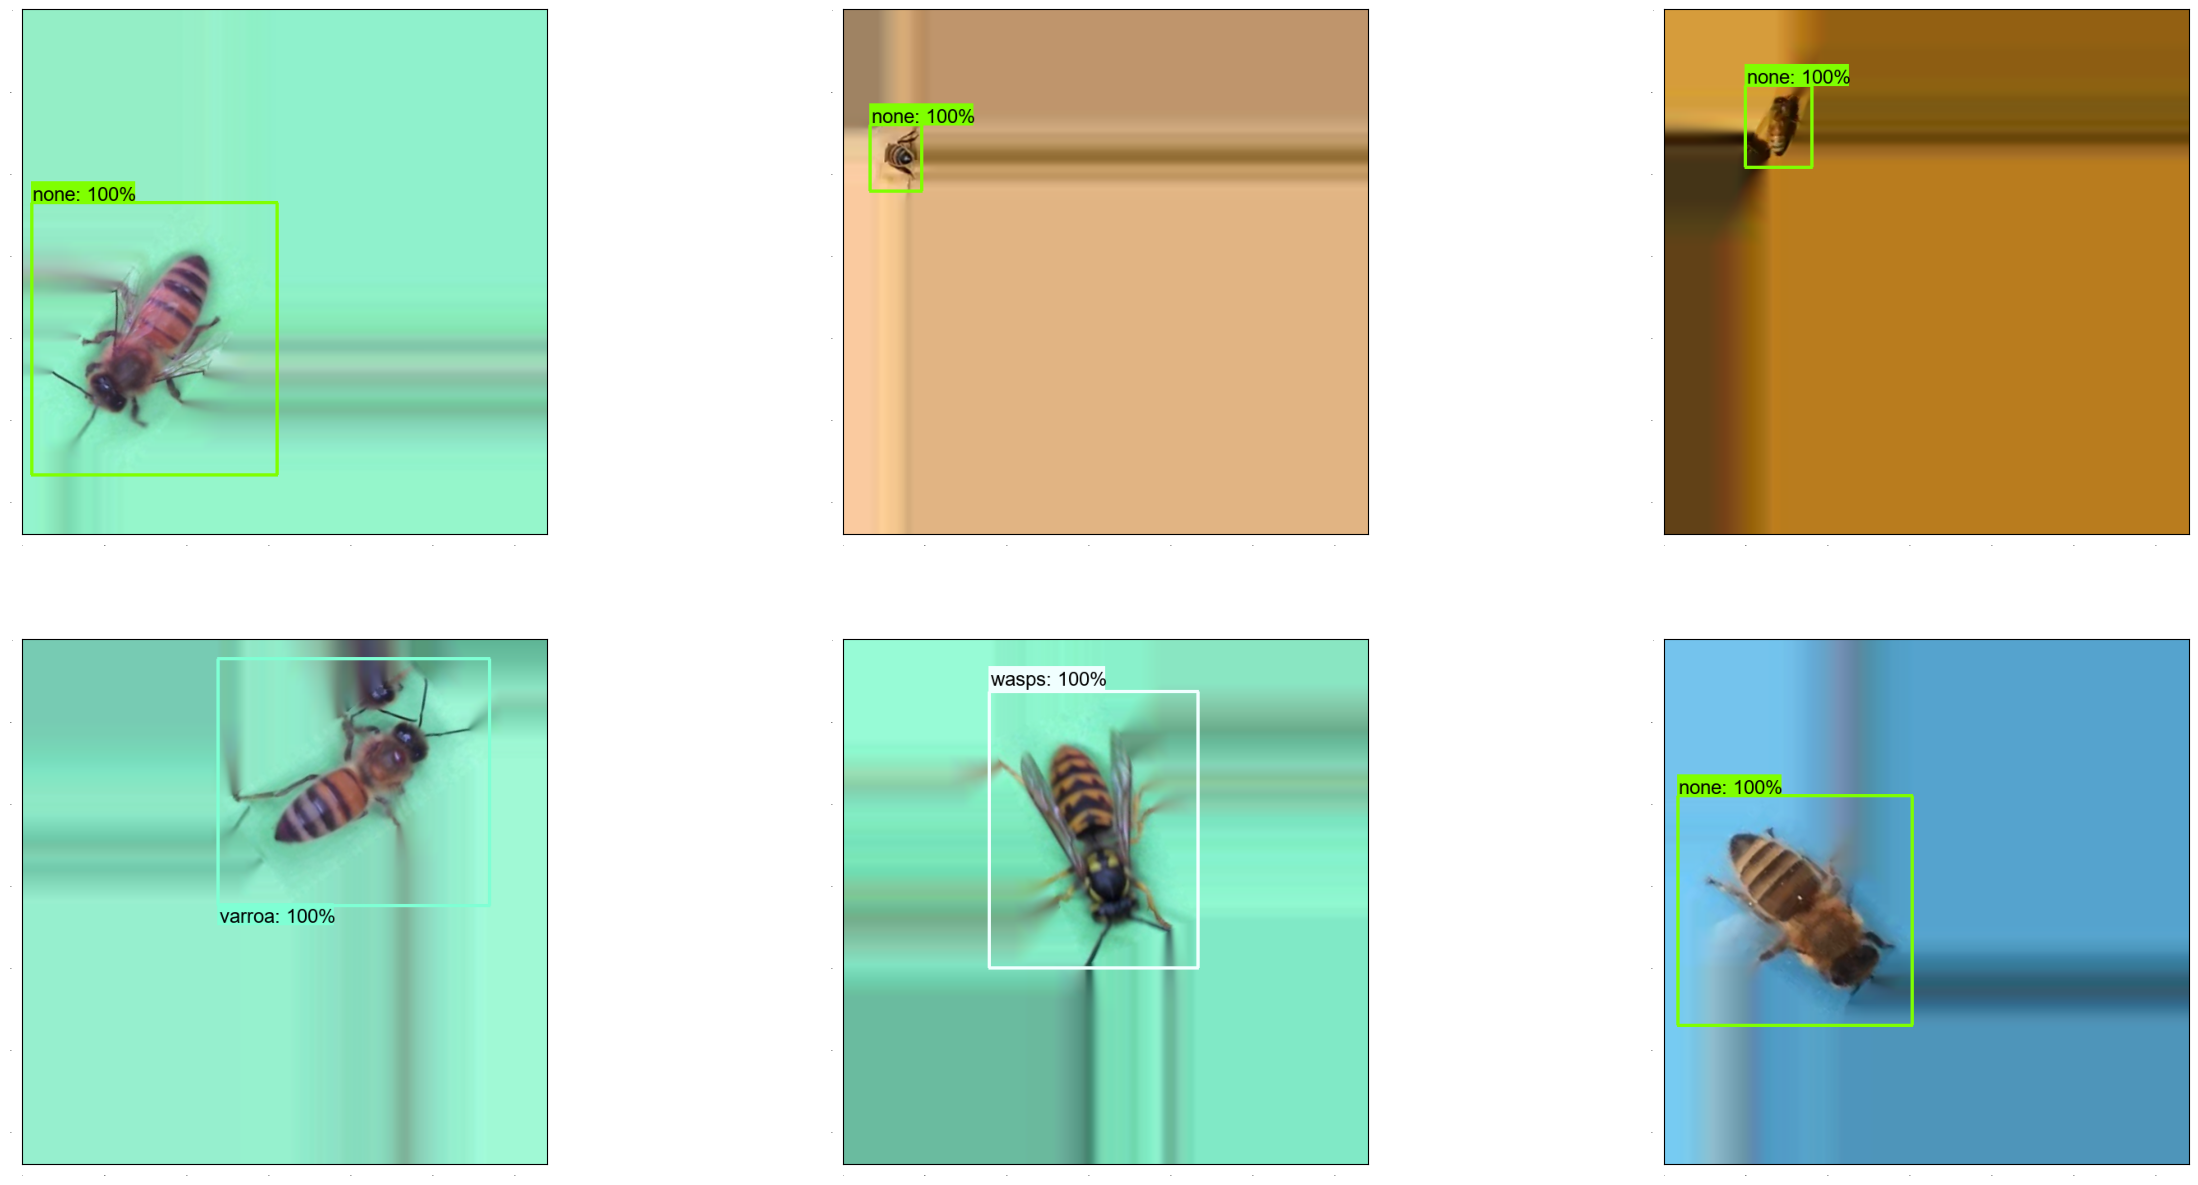

In [4]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [30, 15]

enum_file_subset = []
dummy_scores = np.array([1.0], dtype=np.float32)  # boxes have dummy score of 100%

for i in range(6):
    rand_enum_val = random.randint(0, len(glob.glob(train_augmented_fp + '/*')))
    enum_file_subset.append(glob.glob(train_augmented_fp + '/*')[rand_enum_val])

for idx, filename in enumerate(enum_file_subset):
    plt.subplot(2, 3, idx+1)
    image, label, gt_box = GEORGE.get_file_and_info(filename)
    
    GEORGE.plot_detections(
        image,
        gt_box,
        np.array(label[2]),
        dummy_scores,
        category_index)
plt.show